# 1. Import Libraries

In [1]:
import pandas as pd
import pandas.api.types as ptypes
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import math, os, shutil, datetime
import sqlite3
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 500
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [69]:
import xgboost as xgb

In [4]:
from sklearn.metrics import f1_score, auc, plot_confusion_matrix, plot_roc_curve, roc_auc_score

In [5]:
from sklearn.model_selection import cross_val_score

# Load Data

In [6]:
train_data = pd.read_csv('../Data/Train/Train.csv')
firstcamp_data = pd.read_csv('../Data/Train/First_Health_Camp_Attended.csv')
secondcamp_data = pd.read_csv('../Data/Train/Second_Health_Camp_Attended.csv')
thirdcamp_data = pd.read_csv('../Data/Train/Third_Health_Camp_Attended.csv')
healthcamp_data = pd.read_csv('../Data/Train/Health_Camp_Detail.csv')
patient_data = pd.read_csv('../Data/Train/Patient_Profile.csv')

test_data = pd.read_csv('../Data/test_l0Auv8Q.csv')
submission_data = pd.read_csv('../Data/sample_submmission.csv')

# Data Cleaning

In [7]:
train_final_data = pd.merge(train_data, firstcamp_data.drop('Unnamed: 4', axis=1), how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp1_merge_ind')
train_final_data = pd.merge(train_final_data, secondcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp2_merge_ind')
train_final_data = pd.merge(train_final_data, thirdcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp3_merge_ind')
train_final_data = pd.merge(train_final_data, healthcamp_data, how='left', on='Health_Camp_ID', indicator='healthcamp_merge_ind')
train_final_data = pd.merge(train_final_data, patient_data, how='left', on='Patient_ID', indicator='patient_merge_ind')

In [8]:
train_final_data['Outcome'] = 0
train_final_data.loc[(train_final_data['camp1_merge_ind']=='both') | 
                     (train_final_data['camp2_merge_ind']=='both') |
                     ((train_final_data['camp3_merge_ind']=='both') & (train_final_data['Number_of_stall_visited']>0))
                     ,'Outcome'] = 1

In [9]:
test_final_data = pd.merge(test_data, firstcamp_data.drop('Unnamed: 4', axis=1), how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp1_merge_ind')
test_final_data = pd.merge(test_final_data, secondcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp2_merge_ind')
test_final_data = pd.merge(test_final_data, thirdcamp_data, how='left', on=['Patient_ID', 'Health_Camp_ID'], indicator='camp3_merge_ind')
test_final_data = pd.merge(test_final_data, healthcamp_data, how='left', on='Health_Camp_ID', indicator='healthcamp_merge_ind')
test_final_data = pd.merge(test_final_data, patient_data, how='left', on='Patient_ID', indicator='patient_merge_ind')

In [10]:
date_cols = ['Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']

In [11]:
def to_date(df):
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%d-%b-%y')
    return df

In [12]:
train_final_data = to_date(train_final_data)
test_final_data = to_date(test_final_data)

In [13]:
num_cols = ['Income', 'Education_Score', 'Age']

In [14]:
def to_numeric(df, columns):
    for col in df.columns:
        if (col in num_cols) & ~(ptypes.is_numeric_dtype(df[col])):
            df[col] = df[col].replace({'None':''})
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [15]:
train_final_data = to_numeric(train_final_data, num_cols)
test_final_data = to_numeric(test_final_data, num_cols)

In [16]:
train_final_data.sort_values(['Patient_ID','Registration_Date'])

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Donation,Health_Score,camp1_merge_ind,Health Score,camp2_merge_ind,Number_of_stall_visited,Last_Stall_Visited_Number,camp3_merge_ind,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,healthcamp_merge_ind,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,patient_merge_ind,Outcome
69348,485679,6578,2005-08-22,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,4.0,4.0,both,2005-08-16,2005-10-14,Third,G,2,both,0,0,0,0,NaN,NaN,NaN,2005-08-12,I,NaN,both,1
64479,485679,6555,2005-08-31,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,NaN,NaN,left_only,2005-09-15,2005-09-19,Second,A,2,both,0,0,0,0,NaN,NaN,NaN,2005-08-12,I,NaN,both,0
6484,485680,6543,2006-07-10,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,NaN,NaN,left_only,2005-09-27,2007-11-07,First,F,2,both,0,0,0,0,NaN,NaN,NaN,2006-07-10,A,NaN,both,0
18999,485681,6580,2004-12-20,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,NaN,NaN,left_only,2004-12-22,2005-01-06,First,E,2,both,0,0,0,1,0.0,NaN,46.0,2004-12-19,G,NaN,both,0
2604,485681,6526,2005-01-01,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,NaN,NaN,left_only,2005-01-03,2005-02-20,First,E,2,both,0,0,0,1,0.0,NaN,46.0,2004-12-19,G,NaN,both,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18124,528657,6531,2004-12-11,0,0,0,0,0,20.0,0.670886,both,NaN,left_only,NaN,NaN,left_only,2004-12-09,2004-12-14,First,C,2,both,0,0,0,0,NaN,NaN,NaN,2004-10-25,D,NaN,both,1
32744,528657,6580,2004-12-18,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,NaN,NaN,left_only,2004-12-22,2005-01-06,First,E,2,both,0,0,0,0,NaN,NaN,NaN,2004-10-25,D,NaN,both,0
7632,528657,6526,2004-12-30,0,0,0,0,0,NaN,NaN,left_only,NaN,left_only,NaN,NaN,left_only,2005-01-03,2005-02-20,First,E,2,both,0,0,0,0,NaN,NaN,NaN,2004-10-25,D,NaN,both,0
24471,528657,6536,2005-02-13,0,0,0,0,0,NaN,NaN,left_only,0.102063,both,NaN,NaN,left_only,2005-02-15,2005-02-18,Second,D,2,both,0,0,0,0,NaN,NaN,NaN,2004-10-25,D,NaN,both,1


## Drop unnecessary columns

In [17]:
unnec_cols = ['camp1_merge_ind', 'camp2_merge_ind', 'camp3_merge_ind', 'healthcamp_merge_ind', 'patient_merge_ind']

In [18]:
train_final_data = train_final_data.drop(unnec_cols, axis=1)
test_final_data = test_final_data.drop(unnec_cols, axis=1)

## Missing Imputations

In [19]:
from sklearn.impute import SimpleImputer

### Mean Imputation

In [20]:
mean_impute_cols = ['Age']
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(train_final_data[mean_impute_cols])
train_final_data[mean_impute_cols] = imp_mean.transform(train_final_data[mean_impute_cols])
test_final_data[mean_impute_cols] = imp_mean.transform(test_final_data[mean_impute_cols])

### Frequent Imputation

In [21]:
freq_impute_cols = ['Income', 'Education_Score', 'City_Type', 'Employer_Category']
imp_freq = SimpleImputer(strategy='most_frequent')
imp_freq.fit(train_final_data[freq_impute_cols])
train_final_data[freq_impute_cols] = imp_freq.transform(train_final_data[freq_impute_cols])
test_final_data[freq_impute_cols] = imp_freq.transform(test_final_data[freq_impute_cols])

### Zero Imputation

In [22]:
zero_impute_cols = ['Donation', 'Health_Score', 'Health Score', 'Number_of_stall_visited', 'Last_Stall_Visited_Number']
train_final_data[zero_impute_cols] = train_final_data[zero_impute_cols].fillna(0)
test_final_data[zero_impute_cols] = test_final_data[zero_impute_cols].fillna(0)

### Missing Date Imputation

In [23]:
def date_impute(df):
    midpoint = df['Camp_Start_Date'] + (df['Camp_End_Date'] - df['Camp_Start_Date'])/2
    df['Registration_Date'] = df['Registration_Date'].fillna(midpoint)
    df['Registration_Date'] = pd.to_datetime(df['Registration_Date'], format='%Y-%m-%d')
    return df

In [24]:
train_final_data = date_impute(train_final_data)
test_final_data = date_impute(test_final_data)

# Feature Engineering

## 1. Duration of camp

In [25]:
train_final_data['Camp Duration'] = (train_final_data['Camp_End_Date'] - train_final_data['Camp_Start_Date']).dt.days
test_final_data['Camp Duration'] = (test_final_data['Camp_End_Date'] - test_final_data['Camp_Start_Date']).dt.days

## 2. Registered before/after start of camp

In [26]:
train_final_data['reg_start_diff'] = (train_final_data['Camp_Start_Date'] - train_final_data['Registration_Date']).dt.days
test_final_data['reg_start_diff'] = (test_final_data['Camp_Start_Date'] - test_final_data['Registration_Date']).dt.days

## 3. Days left for camp end?

In [27]:
train_final_data['days_for_camp_end'] = (train_final_data['Registration_Date'] - train_final_data['Camp_End_Date']).dt.days
test_final_data['days_for_camp_end'] = (test_final_data['Registration_Date'] - test_final_data['Camp_End_Date']).dt.days

## 4. Point in camp

In [28]:
train_final_data['point_in_camp'] = 1- train_final_data['days_for_camp_end']/train_final_data['Camp Duration']
test_final_data['point_in_camp'] = 1- test_final_data['days_for_camp_end']/test_final_data['Camp Duration']

## 5. Days since first and last interaction

In [29]:
train_final_data['is_train'] = True
test_final_data['is_train'] = False
all_data = pd.concat([train_final_data,test_final_data])
all_data = all_data.reset_index(drop=True)
all_data = all_data.sort_values(['Patient_ID', 'Registration_Date'])
all_data = all_data.reset_index(drop=True)
patient_wise_visits = all_data.loc[:,['Patient_ID','Registration_Date']]
patient_wise_visits = patient_wise_visits.drop_duplicates()
patient_wise_visits = patient_wise_visits.reset_index(drop=True)
patient_wise_visits['Last_Interaction'] = patient_wise_visits.groupby('Patient_ID')['Registration_Date'].shift()
all_data = pd.merge(all_data,patient_wise_visits,on=['Patient_ID', 'Registration_Date'],how='left')
all_data.loc[all_data['Last_Interaction'].isna(),'Last_Interaction'] = all_data['First_Interaction']
all_data['days_since_first_interaction'] = (all_data['Registration_Date'] - all_data['First_Interaction']).dt.days
all_data['days_since_last_interaction'] = (all_data['Registration_Date'] - all_data['Last_Interaction']).dt.days

## 6. Historic Features

In [30]:
import sqlite3
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
all_data.to_sql('all_data', conn, index=False)

qry = '''
        select a.Patient_ID, a.Registration_Date,
        count(b.Health_Camp_ID) as prev_registration_count,
        sum(b.Outcome) / count(b.Health_Camp_ID) as prev_response_rate,
        sum(case when b.Category2 = 'First' then b.Outcome else NULL end)/
        count( case when b.Category2 = 'First' then b.Health_Camp_ID else NULL end) as prev_first_response_rate,
        sum(case when b.Category2 = 'Second' then b.Outcome else NULL end)/
        count( case when b.Category2 = 'Second' then b.Health_Camp_ID else NULL end) as prev_second_response_rate,
        sum(case when b.Category2 = 'Third' then b.Outcome else NULL end)/
        count( case when b.Category2 = 'Third' then b.Health_Camp_ID else NULL end) as prev_third_response_rate,
        sum(b.Donation) as prev_donation,
        avg(case when b.Category2 = 'First' then b.Donation else NULL end) as prev_donation_avg,
        avg(case when b.Category2 = 'First' then b.Health_Score else NULL end) as prev_avg_health_score1,
        avg(case when b.Category2 = 'Second' then b.[Health Score] else NULL end) as prev_avg_health_score2,
        sum(b.Number_of_stall_visited) as prev_stall_count,
        avg(case when b.Category2 = 'Third' then b.Number_of_stall_visited else NULL end) as prev_stall_count_avg,
        count(distinct b.Last_Stall_Visited_Number) as prev_distinct_stalls
        from all_data as a left join all_data as b 
        on a.Patient_ID = b.Patient_ID 
        and b.Registration_Date < a.Registration_Date 
        group by a.Patient_ID, a.Registration_Date
      '''
patient_history = pd.read_sql_query(qry, conn)
patient_history['Registration_Date'] = pd.to_datetime(patient_history['Registration_Date'], format='%Y-%m-%d')

In [31]:
all_data = pd.merge(all_data,patient_history,on=['Patient_ID','Registration_Date'],how='left')

### Missing imputation for new features

In [32]:
new_feat = ['prev_response_rate', 'prev_first_response_rate', 'prev_second_response_rate', 'prev_third_response_rate',
           'prev_donation', 'prev_donation_avg', 'prev_avg_health_score1', 'prev_avg_health_score2', 'prev_stall_count',
           'prev_stall_count_avg']
all_data[new_feat] = all_data[new_feat].fillna(-999)

In [33]:
train_final_data = all_data.loc[all_data['is_train']==True]
test_final_data = all_data.loc[all_data['is_train']==False]

## Constants

In [34]:
ID1 = 'Patient_ID'
ID2 = 'Health_Camp_ID'
target = 'Outcome'
date_columns = ['Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']
discrete_columns = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Category1', 'Category2', 'Category3', 'Online_Follower', 
                   'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'City_Type', 'Employer_Category']
ignore_cols = [ID1, ID2, target, 'Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction', 
               'Last_Interaction', 'Donation', 'Health_Score', 'Health Score', 'Number_of_stall_visited', 
               'Last_Stall_Visited_Number','is_train']

In [35]:
random_state = 1234

In [38]:
should_ohe = True
should_scale = True

## Scaling

In [39]:
if should_scale:
    for col in train_final_data.columns:
        if (col != target) and (col != ID1) and (col != ID2) and (col not in date_columns) and (col not in discrete_columns) and (col not in ignore_cols):
            mms = MinMaxScaler()
            ss = StandardScaler()
            rs = RobustScaler()
            pt = PowerTransformer()
            ft_log = FunctionTransformer(np.log)
            
            train_final_data[f"{col}_MMS"] = mms.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_MMS"] = mms.transform(test_final_data[[col]])
            
            train_final_data[f"{col}_SS"] = ss.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_SS"] = ss.transform(test_final_data[[col]])
            
            train_final_data[f"{col}_RS"] = rs.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_RS"] = rs.transform(test_final_data[[col]])
            
            train_final_data[f"{col}_PT"] = pt.fit_transform(train_final_data[[col]])
            test_final_data[f"{col}_PT"] = pt.transform(test_final_data[[col]])
            
#             train_final_data[f"{col}_FT_log"] = ft_log.fit_transform(train_final_data[[col]])
#             test_final_data[f"{col}_FT_log"] = ft_log.transform(test_final_data[[col]])

## One hot encoding

In [40]:
cols_for_ohe = ['Category1', 'Category2', 'City_Type', 'Employer_Category']

In [41]:
train_final_data = pd.concat([train_final_data.drop(cols_for_ohe,axis=1),pd.get_dummies(train_final_data[cols_for_ohe])],axis=1)
test_final_data = pd.concat([test_final_data.drop(cols_for_ohe,axis=1),pd.get_dummies(test_final_data[cols_for_ohe])],axis=1)

# Test Train Split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
ignore_cols = [ID1, ID2, target, 'Registration_Date', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction', 
               'Last_Interaction', 'Donation', 'Health_Score', 'Health Score', 'Number_of_stall_visited', 
               'Last_Stall_Visited_Number','is_train']
X, y = train_final_data.drop(ignore_cols, axis=1), train_final_data[target]
X_test = test_final_data.drop(ignore_cols, axis=1)

In [ ]:
X['Category2_']

In [ ]:
X_test['Category2_']

In [61]:
set(X.columns) - set(X_test.columns)

{'Category2_B'}

In [58]:
X_test.shape

(35249, 147)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=random_state)

# Base Models

In [45]:
n_esitmators = 1000
classifiers = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(n_estimators=n_esitmators, random_state=random_state),
    "GBM": GradientBoostingClassifier(n_estimators=n_esitmators, random_state=random_state),
    "GBM_ES": GradientBoostingClassifier(n_estimators=n_esitmators, validation_fraction=0.2, 
                                         n_iter_no_change=5,tol=0.01,random_state=random_state)
}

1 Building DT starts..
	 Mean ROC AUC: 0.7242311847287904 +/- 0.005767169230214337
	 ROC AUC: 0.7301108283866141
It took 0:00:17.042720 time to finish the modelling
1 Building DT ends..
2 Building RF starts..
	 Mean ROC AUC: 0.8727711299493682 +/- 0.0030614171340865616
	 ROC AUC: 0.7751438074740756
It took 0:15:40.404051 time to finish the modelling
2 Building RF ends..
3 Building GBM starts..
	 Mean ROC AUC: 0.8685662380860146 +/- 0.0036523462318313444
	 ROC AUC: 0.757465126647443
It took 0:34:27.891683 time to finish the modelling
3 Building GBM ends..
4 Building GBM_ES starts..
	 Mean ROC AUC: 0.8488960367443434 +/- 0.003132391500625297
	 ROC AUC: 0.720469220135193
It took 0:00:59.801718 time to finish the modelling
4 Building GBM_ES ends..


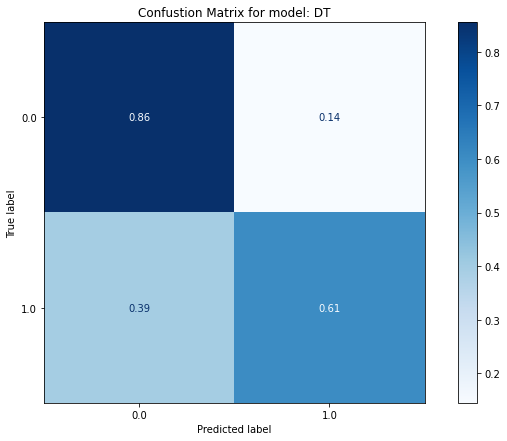

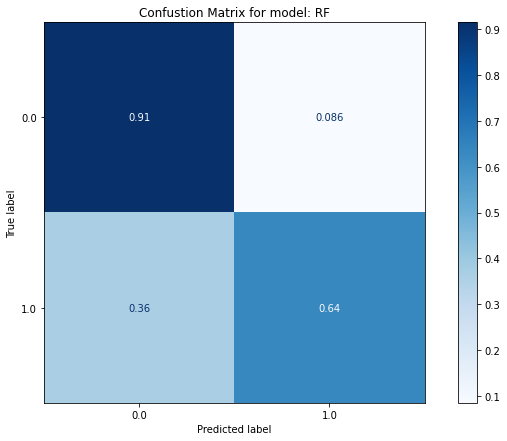

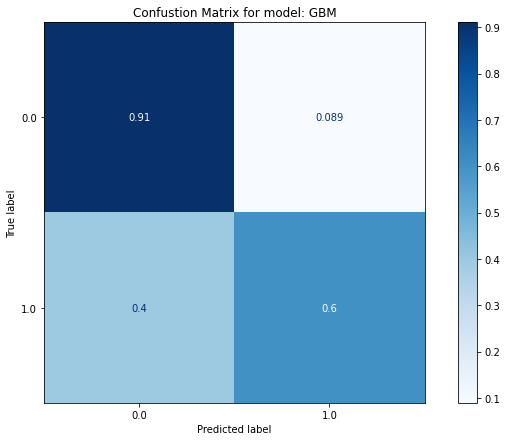

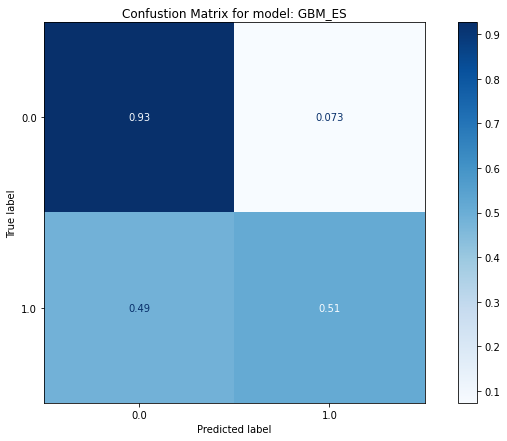

In [46]:
clf_ct=0
for model_name,clf in classifiers.items():
    print(f"{clf_ct+1} Building {model_name} starts..")
    start_ts = datetime.datetime.now()
    
    cv_scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)
    print(f"\t Mean ROC AUC: {np.mean(cv_scores)} +/- {np.std(cv_scores)}")
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    auc_score = roc_auc_score(y_val, predictions)
    print(f"\t ROC AUC: {auc_score}")
    
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    disp = plot_confusion_matrix(clf, X_val, y_val, normalize='true', ax=ax, cmap=plt.cm.Blues)
    disp.ax_.set_title(f"Confustion Matrix for model: {model_name}")
    os.makedirs("../plots/confusion_matrix_scale_ohe",exist_ok=True)
    plt.savefig(f"../plots/confusion_matrix_scale_ohe/{model_name}.png", dpi=300)
    end_ts = datetime.datetime.now()
    
    print(f"It took {end_ts - start_ts} time to finish the modelling")
    print(f"{clf_ct+1} Building {model_name} ends..")
    
    clf_ct+=1
    

In [51]:
var_imp = pd.DataFrame({'var':X.columns, 'var_imp':classifiers['GBM_ES'].feature_importances_})

In [66]:
gbm_es = GradientBoostingClassifier(n_estimators=100, validation_fraction=0.2, n_iter_no_change=50,tol=0.01,
                                    random_state=random_state, learning_rate=0.001)

Building GBM with early stopping starts..
	 Mean ROC AUC: 0.8233233444226002 +/- 0.005562552704426116
	 ROC AUC: 0.720469220135193
It took 0:03:56.249546 time to finish the modelling
Building GBM with early stopping ends..


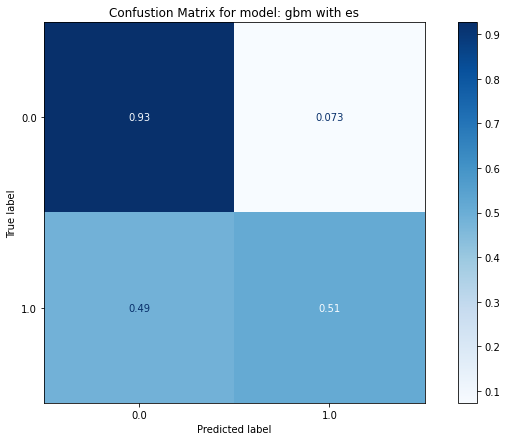

In [67]:
print(f"Building GBM with early stopping starts..")
start_ts = datetime.datetime.now()

cv_scores = cross_val_score(gbm_es, X_train, y_train, scoring='roc_auc', cv=5)
print(f"\t Mean ROC AUC: {np.mean(cv_scores)} +/- {np.std(cv_scores)}")

gbm_es.fit(X_train, y_train)
predictions = clf.predict(X_val)
auc_score = roc_auc_score(y_val, predictions)
print(f"\t ROC AUC: {auc_score}")

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
disp = plot_confusion_matrix(clf, X_val, y_val, normalize='true', ax=ax, cmap=plt.cm.Blues)
disp.ax_.set_title(f"Confustion Matrix for model: gbm with es")
os.makedirs("../plots/confusion_matrix_scale_ohe",exist_ok=True)
plt.savefig(f"../plots/confusion_matrix_scale_ohe/gbm with es.png", dpi=300)
end_ts = datetime.datetime.now()

print(f"It took {end_ts - start_ts} time to finish the modelling")
print(f"Building GBM with early stopping ends..")

In [ ]:
xgb = xgb.

In [ ]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_validate = xgb.DMatrix(X_validate, label=Y_validate)
D_test = xgb.DMatrix(test_set.drop( exclusions,axis=1))

param = {
    'eta': 0.01, 
    'max_depth': 6,  
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
    } 

steps = 1000

baseline_model = xgb.train(param, D_train, steps,early_stopping_rounds = 50, verbose_eval = 50,
                           evals = [(D_train,'train'),(D_validate,'eval')])

preds = baseline_model.predict(D_validate)

print(roc_auc_score(Y_validate,preds))